# Advanced Data Science - Capstone Project

## Model Deployment - V.1.0

### Carlos Granados

For this project I decided to use solar power generation data uploaded by [Ani Kannal](https://www.kaggle.com/anikannal "Ani Kannal Profile") in [kaggle.com website](https://www.kaggle.com/anikannal/solar-power-generation-data?select=Plant_1_Generation_Data.csv "Data Set from kaggle"). The idea is to predict the power generation given different weather conditions, as temperature and irradiation, and check the health of the devices.

### 0. Install TensorFlow and Keras:

Usually `TensorFlow` and `keras` are not installed by default, so we need to install them first...

In [ ]:
!pip install tensorflow==2.2.0rc0

In [ ]:
# On labs.cognitiveclass.ai the V 2.4.3 must be installed
# On IBM Watson it is not necessary to specify
!pip install keras==2.4.3

### 1. Load Libraries:

In [3]:
# Standard python libraries
import numpy as np
import types
import datetime as dt
from scipy import stats
from numpy.random import seed
from math import ceil

# pandas
import pandas as pd

# Libraries to make plots and related
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# For Anomaly Detection, using keras
from keras.models import load_model
from keras.losses import MSE, MSLE
from keras.callbacks import Callback
import tensorflow as tf

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from joblib import dump, load

# Custom functions used through this notebook:
from ADS_Capstone_model_evaluation_Aux import *

# Custom functions defined in other part of the project and needed here:
from ADS_Capstone_model_train_Aux import divideTimeSteps, dataProcess
from ADS_Capstone_model_train_Aux import customNorm, create_trimmed_data_norm

# Others, required by IBM Watson
#import ibm_boto3
#from botocore.client import Config

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


### 2. Re-Read and Check Data Frames

Before to start, lets repeat a couple of steps performed in the *Data Exploration* step.

Some cells are hidden, because they contain sensitive information, as some keys and passwords. The original data files, in CSV format, are already uploaded to IBM Watson project, and they are called from the notebook directly.

#### Note:
When using IBM Watson, the following cells can be (uncommented and) executed in order to read de CSV files directly from the cloud. Otherwise the files must be loaded more "traditionally" (see below)

#### Note:
Execute the following lines when running on cognitiveclass.ai or another platform...

In [4]:
# Path to CSV data files
#path_data = '/resources/Projects/AnomalyDect/SolarPanels/Data/'
path_data = './Data/'

# Read generation data for Plant 1
df_plant1_gen = pd.read_csv(path_data+'Plant_1_Generation_Data.csv')

# Read sensor data for Plant 1
df_plant1_sen = pd.read_csv(path_data+'Plant_1_Weather_Sensor_Data.csv')

In [5]:
# Read generation data for Plant 2
df_plant2_gen = pd.read_csv(path_data+'Plant_2_Generation_Data.csv')

# Read sensor data for Plant 2
df_plant2_sen = pd.read_csv(path_data+'Plant_2_Weather_Sensor_Data.csv')

We create now a huge function that makes all the ETL, data cleasing and feature engineering for us!

In [6]:
# Create DF with all times...
t = np.arange(0, 24, 0.25)
times = []
headers = ['TIME', 'DAY', 'MONTH']

# Add days for May
for day in range(15, 32):
    for i in range(96):
        times.append([t[i], day, 5])

# Add days for June
for day in range(1, 18):
    for i in range(96):
        times.append([t[i], day, 6])
        
times = np.array(times)
df_times = pd.DataFrame(data=times, columns=headers)

Let's extract the 7 first sources for the plant 1 (used for training):

In [7]:
nDay_p1 = 10
nMonth_p1 = 5
df1_all = dataProcess(df_plant1_gen, df_plant1_sen, df_times, 7, nDay=nDay_p1, nMonth=nMonth_p1)

Extracting data for Source Key : bvBOhCH3iADSZry
Extracting data for Source Key : 1BY6WEcLGh8j5v7
Extracting data for Source Key : VHMLBKoKgIrUVDU
Extracting data for Source Key : 7JYdWkrLSPkdwr4
Extracting data for Source Key : ih0vzX44oOqAx2f
Extracting data for Source Key : ZnxXDlPa8U1GXgE
Extracting data for Source Key : z9Y9gH1T5YWrNuG


And now some additional data sources, for evaluate the model...

In [8]:
df1_new = dataProcess(df_plant1_gen, df_plant1_sen, df_times, 15, nDay=nDay_p1, nMonth=nMonth_p1)

Extracting data for Source Key : bvBOhCH3iADSZry
Extracting data for Source Key : 1BY6WEcLGh8j5v7
Extracting data for Source Key : VHMLBKoKgIrUVDU
Extracting data for Source Key : 7JYdWkrLSPkdwr4
Extracting data for Source Key : ih0vzX44oOqAx2f
Extracting data for Source Key : ZnxXDlPa8U1GXgE
Extracting data for Source Key : z9Y9gH1T5YWrNuG
Extracting data for Source Key : wCURE6d3bPkepu2
Extracting data for Source Key : iCRJl6heRkivqQ3
Extracting data for Source Key : uHbuxQJl8lW7ozc
Extracting data for Source Key : pkci93gMrogZuBj
Extracting data for Source Key : rGa61gmuvPhdLxV
Extracting data for Source Key : sjndEbLyjtCKgGv
Extracting data for Source Key : zVJPv84UY57bAof
Extracting data for Source Key : McdE0feGgRqW7Ca


And for the 7 first sources for the plant 2:

In [9]:
df1_eval = genTest(df1_all, df1_new, 8.00, nDay_p1, nMonth_p1,
                   n0=5, n1=5, x0=0.65, verbose=0)

In [10]:
df1_eval[0].describe()

,TIME,DAY,MONTH,AMB_TEMP,MOD_TEMP,IRRADIATION,AC_POWER,DC_POWER
count,16.000000,16.0,16.0,16.000000,16.000000,16.000000,16.000000,16.000000
mean,9.875000,17.0,5.0,29.142192,49.687791,0.676743,809.268304,8274.642857
std,1.190238,0.0,0.0,2.364151,8.262481,0.203506,218.635341,2246.655085
min,8.000000,17.0,5.0,25.061761,34.632715,0.378702,473.971429,4832.000000
25%,8.937500,17.0,5.0,27.520126,44.952106,0.531785,642.169643,6555.700893
50%,9.875000,17.0,5.0,29.630904,49.436558,0.701713,880.883036,9004.598215
75%,10.812500,17.0,5.0,31.091784,55.328591,0.823069,1003.557143,10275.142855
max,11.750000,17.0,5.0,32.527864,63.145582,0.997904,1093.014286,11185.428570


In [11]:
df1_eval[1].describe()

,TIME,DAY,MONTH,AMB_TEMP,MOD_TEMP,IRRADIATION,AC_POWER,DC_POWER
count,16.000000,16.0,16.0,16.000000,16.000000,16.000000,16.000000,16.000000
mean,9.875000,17.0,5.0,29.142192,49.687791,0.676743,526.024397,5378.517857
std,1.190238,0.0,0.0,2.364151,8.262481,0.203506,142.112972,1460.325805
min,8.000000,17.0,5.0,25.061761,34.632715,0.378702,308.081429,3140.800000
25%,8.937500,17.0,5.0,27.520126,44.952106,0.531785,417.410268,4261.205580
50%,9.875000,17.0,5.0,29.630904,49.436558,0.701713,572.573973,5852.988839
75%,10.812500,17.0,5.0,31.091784,55.328591,0.823069,652.312143,6678.842856
max,11.750000,17.0,5.0,32.527864,63.145582,0.997904,710.459286,7270.528571


### 3. Deep Learning Model

In the model definition phase we explored different deep learning models, and the one that had the best behavior were a sequential one, with several layers. In the training phase such model were used and saved. Here we load such model and use it in two stages: 1.) to evaluate how good the model is and 2.) using it when "broken" data is used to verify how the losses change and then to identify a possible problem in the solar panels.

The FFT of the data is not considered, since several of the time parameters (such as time and day and month) are needed to build up the model.

Function to detect an anomaly, based on the changes of the loss function. A warning is issued if a change larger than the `l_min` value is detected. In the training phase we see that such values are arond `l_min = 0.075`.

In [33]:
def checkVal(score, indx=0):
    """
    Function to check the Anomaly boolean value in score DF
    """
    s0 = score['Anomaly'].unique()
    if True in s0:
        print('Warning! Possible anomaly detected in entry {}'.format(indx))

def checkPanel(df_test, df_eval, time_steps, batch_size, model, scaler,
               lossFun='mse', l_min=0.1):
    """
    Function designed to give warnings, when the loss function is larger than a given value
    df_test : DF, using for the training of model
    df_eval : DF, used to test the validity of model
    model   : previusly trained model, using df_test
    loss    : (str) loss function to use. 'MSE' by default
    """
    # Check loss with data used during the training phase
    score_all = {}
    icount = 0
    keys = list(df_test.keys())
    i_min = min(keys)
    for i in df_test:
        df = df_test[i]
        if i == i_min:
            score = predictModel(df, model, create_trimmed_data_norm,
                                 scaler, time_steps, batch_size,
                                 lossFun=lossFun, l_min=l_min)
            checkVal(score)
        else:
            score_loop = predictModel(df, model, create_trimmed_data_norm,
                                      scaler, time_steps, batch_size,
                                      lossFun=lossFun, l_min=l_min)
            checkVal(score_loop, indx=-i)
            score = pd.concat([score_loop, score])
    score_all[icount] = score
    icount += 1
    # Check the loss for each validation data
    loss_val = {}
    for i in df_eval:
        df = df_eval[i]
        score = predictModel(df, model, create_trimmed_data_norm,
                             scaler, time_steps, batch_size,
                             lossFun=lossFun, l_min=l_min)
        score_all[icount] = score
        loss_val[i] = score
        icount += 1
        # Check if there is some anomalies (loss values over the threshold)
        checkVal(score, indx=i)
    return [score_all, loss_val]

#### 3.2 Deep Learning Model:

We start demonstraring how the deep learming model performs.

We load the model for the solar panel 1:

In [13]:
model1 = load_model('./models/ADS_Capstone.solar_panel_1.model.h5')

Let's check the summary:

In [14]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 20)            2320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 20)            3280      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16, 20)            3280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16, 20)            3280      
_________________________________________________________________
lstm_4 (LSTM)                (None, 16, 20)            3280      
_________________________________________________________________
lstm_5 (LSTM)                (None, 16, 20)            3280      
_________________________________________________________________
lstm_6 (LSTM)                (None, 16, 20)            3

And the distribution of the losses during the training phase:

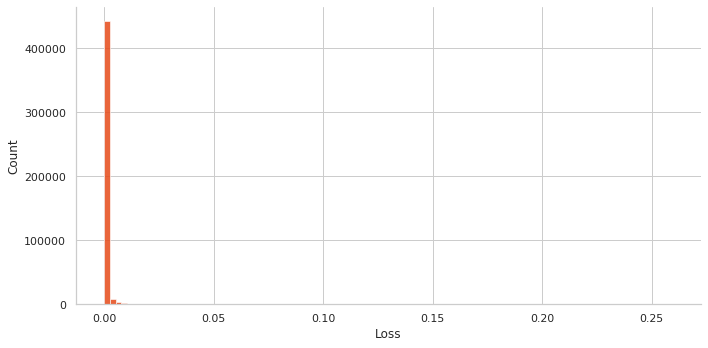

In [159]:
# Distribution plot

distLoss(lossAll_m1, lossFun, optFun, bins=100)

For some of the data using during the training, we obtained the scores:

In [21]:
time_steps = 16      # Equivalent to obtained observations in a 4 hour period
dim = 8              # Number of considered parameters
batch_size = 4      # Best batch:size obtained in evaluation of the model

# Initialize scaler
scaler1 = customNorm(df_plant1_gen, df_plant1_sen)

df1_check = {i:df1_all[i] for i in range(20, 30)}

# Check loss for data used in training
scoreAll(df1_check, time_steps, scaler1, model1)

df : 20
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.060608
std       0.026950
min       0.040953
25%       0.042169
50%       0.043486
75%       0.085870
max       0.116305
Name: Loss, dtype: float64
---------------------------

df : 21
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.141175
std       0.058864
min       0.069155
25%       0.115781
50%       0.122548
75%       0.146420
max       0.301124
Name: Loss, dtype: float64
---------------------------

df : 22
1/1 [==============================] - 0s 875us/step
Loss : count    16.000000
mean      0.018987
std       0.016057
min       0.010190
25%       0.010383
50%       0.011392
75%       0.018661
max       0.069095
Name: Loss, dtype: float64
---------------------------

df : 23
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.006671
std       0.000390
min       0.006379
25%       0.006409
50%       0.006

And for the new data sets:

In [22]:
scoreAll(df1_eval, time_steps, scaler1, model1)

df : 0
1/1 [==============================] - 0s 857us/step
Loss : count    16.000000
mean      0.193208
std       0.080922
min       0.083423
25%       0.127732
50%       0.208926
75%       0.266618
max       0.314830
Name: Loss, dtype: float64
---------------------------

df : 1
1/1 [==============================] - 0s 2ms/step
Loss : count    16.000000
mean      0.142593
std       0.056866
min       0.067230
25%       0.095852
50%       0.150062
75%       0.189677
max       0.234648
Name: Loss, dtype: float64
---------------------------

df : 2
1/1 [==============================] - 0s 989us/step
Loss : count    16.000000
mean      0.111243
std       0.032005
min       0.061529
25%       0.081044
50%       0.113519
75%       0.134990
max       0.165394
Name: Loss, dtype: float64
---------------------------

df : 3
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.024283
std       0.019957
min       0.012876
25%       0.013078
50%       0.01432

1/1 [==============================] - 0s 7ms/step
Loss : count    16.000000
mean      0.097512
std       0.036955
min       0.054596
25%       0.080625
50%       0.085406
75%       0.100189
max       0.199640
Name: Loss, dtype: float64
---------------------------

df : 31
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.018600
std       0.015890
min       0.010190
25%       0.010383
50%       0.011252
75%       0.017349
max       0.069095
Name: Loss, dtype: float64
---------------------------

df : 32
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.186726
std       0.085300
min       0.058819
25%       0.122544
50%       0.175410
75%       0.230584
max       0.340056
Name: Loss, dtype: float64
---------------------------

df : 33
1/1 [==============================] - 0s 1ms/step
Loss : count    16.000000
mean      0.135607
std       0.057137
min       0.052367
25%       0.091010
50%       0.129641
75%   

Let's check if some issues are printed!

In [34]:
[score, loss_eval] = checkPanel(df1_check, df1_eval, time_steps,
                                batch_size, model1, scaler1,
                                lossFun='msle', l_min=0.075)

1/1 [==============================] - 0s 957us/step
Warning! Possible anomaly detected in entry -21
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry -26
1/1 [==============================] - 0s 964us/step
Warning! Possible anomaly detected in entry -27
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry 0
1/1 [==============================] - 0s 2ms/step
Warning! Possible anomaly detected in entry 1
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry 2
1/1 [==============================] - 0s 2ms/step
Warning! Possible anomaly detected in entry 4
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry 5
1/1 [==============================] - 0s 5ms/step
Warning! Possible anomaly detected in entry 6
1/1 [==============================] - 0s 1ms/step
Warning! Possible anomaly detected in entry 8
1/1 [===============

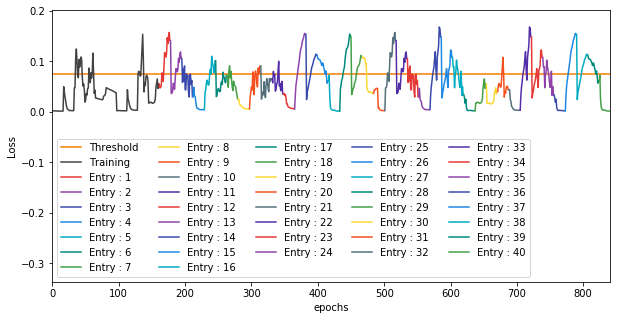

In [36]:
plotLosses(score, c_xmin=0.0, c_ymin=-2.0, c_ymax=1.2)

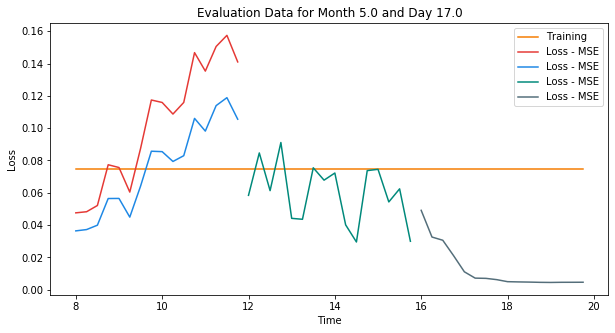

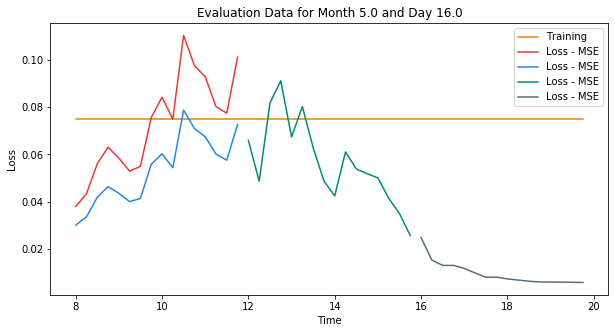

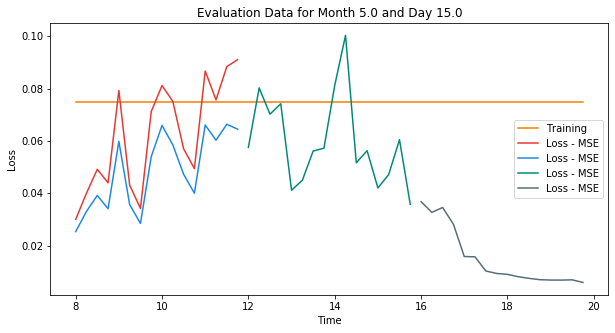

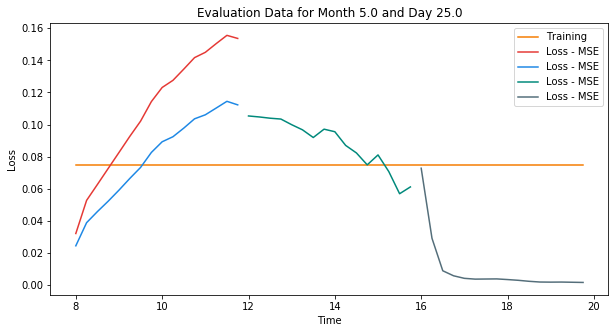

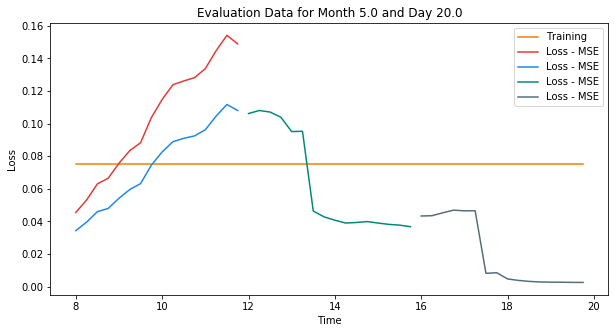

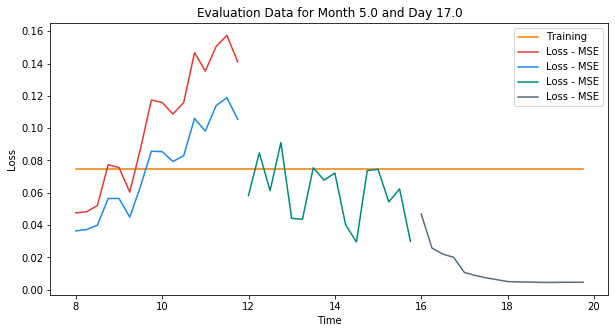

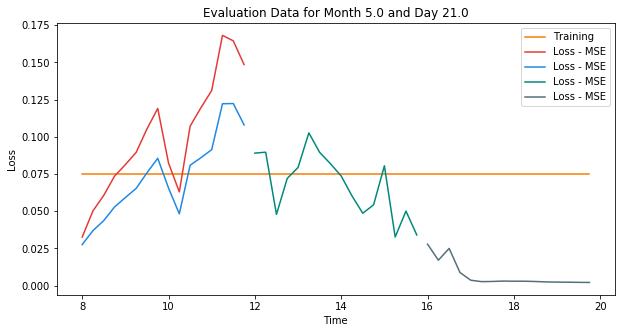

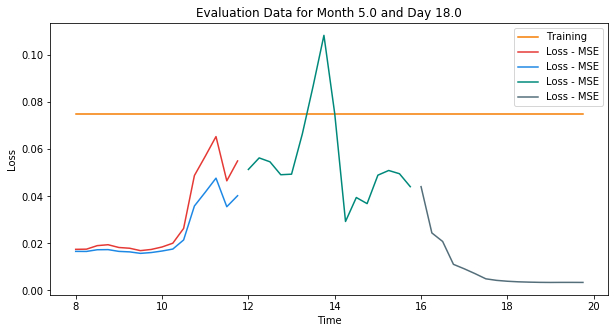

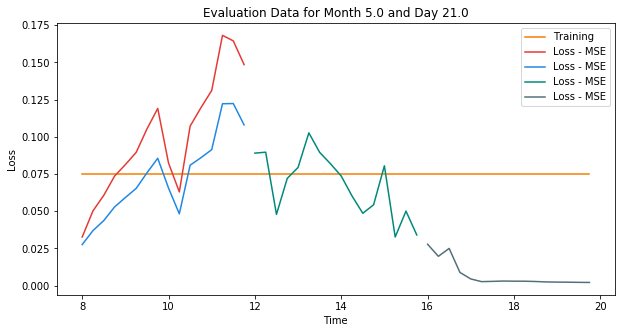

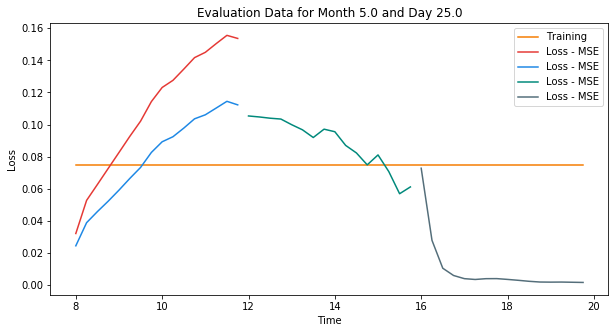

In [37]:
plotTimeLosses(df1_eval, loss_eval)

In [39]:
score[0]

,Loss,Threshold,Anomaly
0,0.002094,0.075,False
1,0.002006,0.075,False
2,0.002072,0.075,False
3,0.002149,0.075,False
4,0.002010,0.075,False
5,0.002008,0.075,False
6,0.001744,0.075,False
7,0.001636,0.075,False
8,0.001636,0.075,False
9,0.001679,0.075,False


### 4. Machine Learning Model

In the model definition phase we trained a linear regression machine learning model, usign polynomial features, in order create a model that helps us to make an anomaly detector. We will use the same evaluation data as for the deep learning model.

The FFT of the data is not considered, since several of the time parameters (such as time and day and month) are needed to build up the model.

In [40]:
def checkVal_LR(score, indx=0):
    """
    Function to check the Anomaly boolean value in score DF
    """
    if score <= 0.75 and score != 0.0:
        print('Warning! Possible anomaly detected in entry {}'.format(indx))

def checkPanel_LR(df_test, df_eval, pipe):
    """
    Function designed to give warnings, when the loss function is larger than a given value
    df_test : DF, using for the training of model
    df_eval : DF, used to test the validity of model
    model   : previusly trained model, using df_test
    loss    : (str) loss function to use. 'MSE' by default
    """
    # Check loss with data used during the training phase
    score_all = {}
    score = []
    icount = 0
    for i in df_test:
        df = df_test[i]
        r2 = predictModel_LR(df, pipe)
        checkVal_LR(r2, indx=-i)
        score.append(r2)
    score_all[icount] = score
    icount += 1
    # Check the loss for each validation data
    r2_val = {}
    for i in df_eval:
        df = df_eval[i]
        score = predictModel_LR(df, pipe)
        score_all[icount] = score
        r2_val[i] = score
        icount += 1
        # Check if there is some anomalies (loss values over the threshold)
        checkVal_LR(score, indx=i)
    return [score_all, r2_val]

Load the trained model:

In [41]:
pipe1 = load('./models/ADS_Capstone.solar_panel_1.ml-deg3.joblib')
print('Model loaded')

Model loaded


In [42]:
scoreAll_LR(df1_check, pipe1)

df : 20
R2 : 0.9925075863949874
MSE : 26533.26069363776
MAE : 103.67187500000003
---------------------------

df : 21
R2 : 0.917262162991984
MSE : 270574.42934320285
MAE : 478.30468768750006
---------------------------

df : 22
R2 : 0.9911035276704409
MSE : 24567.090875077043
MAE : 93.07031245625001
---------------------------

df : 23
R2 : 0.0
MSE : 800.0
MAE : 22.0
---------------------------

df : 24
R2 : 0.0
MSE : 688.0
MAE : 23.0
---------------------------

df : 25
R2 : 0.994931795243462
MSE : 5899.32222987755
MAE : 56.459821443749995
---------------------------

df : 26
R2 : 0.8825366968293693
MSE : 665240.3863729553
MAE : 662.5703125625
---------------------------

df : 27
R2 : 0.9746959279740737
MSE : 237821.35219119125
MAE : 430.2098214375
---------------------------

df : 28
R2 : 0.9939307017963517
MSE : 24299.979147639035
MAE : 114.05022325
---------------------------

df : 29
R2 : 0.0
MSE : 752.0
MAE : 23.0
---------------------------

Mean R2 : 0.6746968398900668
Mean MSE

In [43]:
scoreAll_LR(df1_eval, pipe1)

df : 0
R2 : 0.8782421926141826
MSE : 576157.077562375
MAE : 527.0825891874999
---------------------------

df : 1
R2 : -5.12289851398833
MSE : 12241308.89163424
MAE : 3315.4821429093745
---------------------------

df : 2
R2 : -5.197471495350931
MSE : 10247289.220212938
MAE : 3060.7928011187496
---------------------------

df : 3
R2 : 0.9690144172238742
MSE : 103367.68077118302
MAE : 194.69832587937498
---------------------------

df : 4
R2 : 0.9018585011958502
MSE : 220505.9248849285
MAE : 366.06696424999996
---------------------------

df : 5
R2 : -4.868477763083686
MSE : 5570828.049463117
MAE : 2307.16629463125
---------------------------

df : 6
R2 : -4.365455457961028
MSE : 9344442.684675826
MAE : 2985.041964221875
---------------------------

df : 7
R2 : 0.9388639982412553
MSE : 70201.82166045008
MAE : 171.47081478437494
---------------------------

df : 8
R2 : 0.3407788698311487
MSE : 1611679.9845634499
MAE : 1053.0904019374998
---------------------------

df : 9
R2 : -7.0532859

In [44]:
[r2_all, r2_val] = checkPanel_LR(df1_all, df1_eval, pipe1)

Warning! Possible anomaly detected in entry -2
Warning! Possible anomaly detected in entry -39
Warning! Possible anomaly detected in entry -57
Warning! Possible anomaly detected in entry -63
Warning! Possible anomaly detected in entry -68
Warning! Possible anomaly detected in entry -104
Warning! Possible anomaly detected in entry -105
Warning! Possible anomaly detected in entry -111
Warning! Possible anomaly detected in entry -123
Warning! Possible anomaly detected in entry -134
Warning! Possible anomaly detected in entry -170
Warning! Possible anomaly detected in entry -236
Warning! Possible anomaly detected in entry -326
Warning! Possible anomaly detected in entry -398
Warning! Possible anomaly detected in entry -399
Warning! Possible anomaly detected in entry -411
Warning! Possible anomaly detected in entry 1
Warning! Possible anomaly detected in entry 2
Warning! Possible anomaly detected in entry 5
Warning! Possible anomaly detected in entry 6
Warning! Possible anomaly detected in 

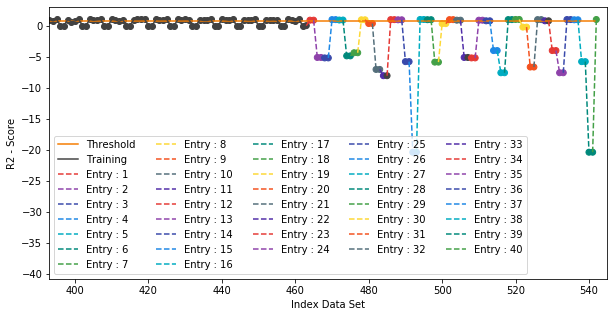

In [45]:
plotR2(r2_all)